# MFM simulations

Phase shift of Magnetic Force Microscopy cantilever
\begin{equation}
    \Delta \phi = \frac{Q\mu_0}{k} \left( q \frac{\partial {\bf H}_{sz}}{\partial z} + {\bf M}_t \cdot \frac{\partial^2{\bf H}_{s}}{\partial z^2} \right). \label{Eq:C7:MFM_phase_Full}
\end{equation}

where (I will assume the tip is a delta function for now),
$Q$ is the quality factor of the cantilever,
$k$ is the spring constant of the cantilever,
$q$ is the magnetic monopole moment of the tip,
${\bf M}_t$ is the magnetic dipole moment of the tip and,
${\bf H}_{sz}$ is the magnetic field due to the sample.


### Importing Packages

In [18]:
%matplotlib notebook
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import random
import matplotlib.pyplot as plt

### Magnetisation data

Perform micromagnetic simulation or load from file.

In [19]:
region = df.Region(p1=(0, 0, -50e-9), p2=(150e-9, 150e-9, 100e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

system = mm.System(name='box2')

system.energy = (mm.Exchange(A=8.78e-12)
               + mm.DMI(D=3e-3, crystalclass='T') #1.58e-3
               #+ mm.UniaxialAnisotropy(K=0.8e6, u=(0, 0, 1))
               + mm.Demag()
               + mm.Zeeman(H=(0, 0, 10e4)))

In [20]:
Ms = 384e3

    
def Ms_fun(pos):
    """Function to set magnitude of magnetisation: zero above the sample,
    Ms inside sample.

    Sample thickness is 50nm.

    """
    x, y, z = pos
    if (z < 0):
        return Ms
    else:
        return 0
    
def m_t_q(pos):
    """
    Function to make a tripple q structure with a period of 50 nm
    
    """
    q = 2*np.pi/(50e-9)
    x, y, z = pos
    
    m_x = 1*(np.sqrt(3)/3)*(- (np.sqrt(3)/2)*np.sin(q*(-0.5*x+np.sqrt(3)*y/2)) 
                            + (np.sqrt(3)/2)*np.sin(q*(-0.5*x-np.sqrt(3)*y/2)))
    m_y = 1*(np.sqrt(3)/3)*(np.sin(q*(x)) 
                            - (1/2)*np.sin(q*(-0.5*x+np.sqrt(3)*y/2)) 
                            - (1/2)*np.sin(q*(-0.5*x-np.sqrt(3)*y/2)) )
    m_z = (1+ 1*(np.sqrt(3)/3)*(-np.cos(q*(x))
                                - np.cos(q*(-0.5*x+np.sqrt(3)*y/2))
                                - np.cos(q*(-0.5*x-np.sqrt(3)*y/2))))
    return (m_x, m_y, m_z)

<IPython.core.display.Javascript object>


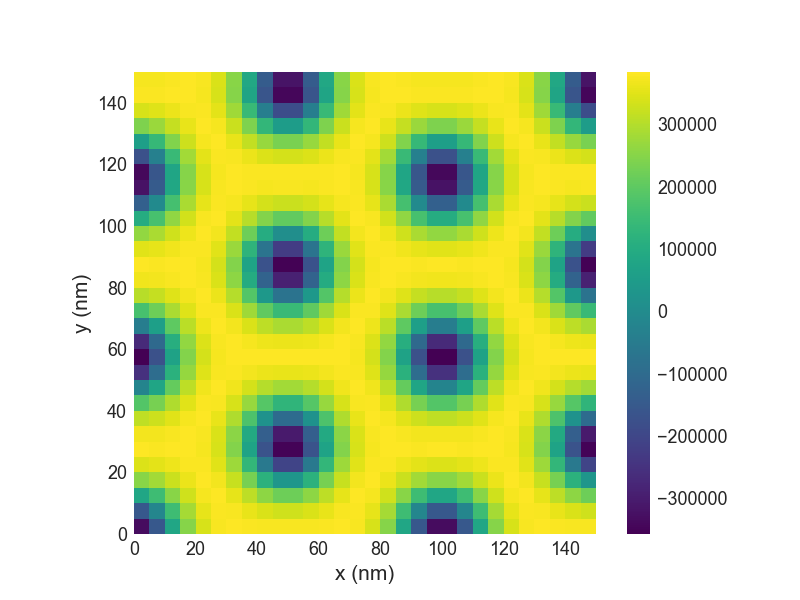

In [23]:
system.m = df.Field(mesh, dim=3, value=m_t_q, norm=Ms_fun)
system.m.z.plane(z=-5e-9).mpl()

<IPython.core.display.Javascript object>


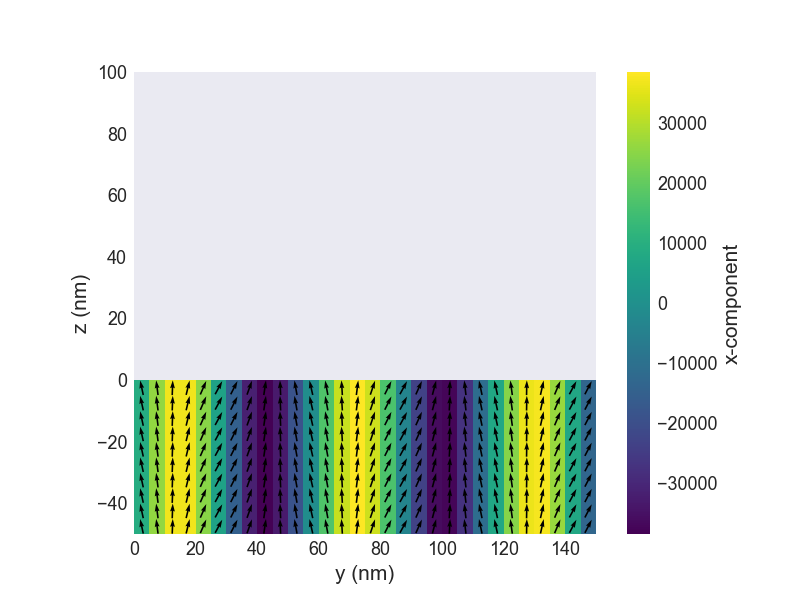

In [24]:
system.m.plane('x').mpl()

In [25]:
# minimize the energy
md = oc.MinDriver()
md.drive(system)

Running OOMMF (DockerOOMMFRunner) [2021/07/09 09:26]... (23.5 s)


<IPython.core.display.Javascript object>


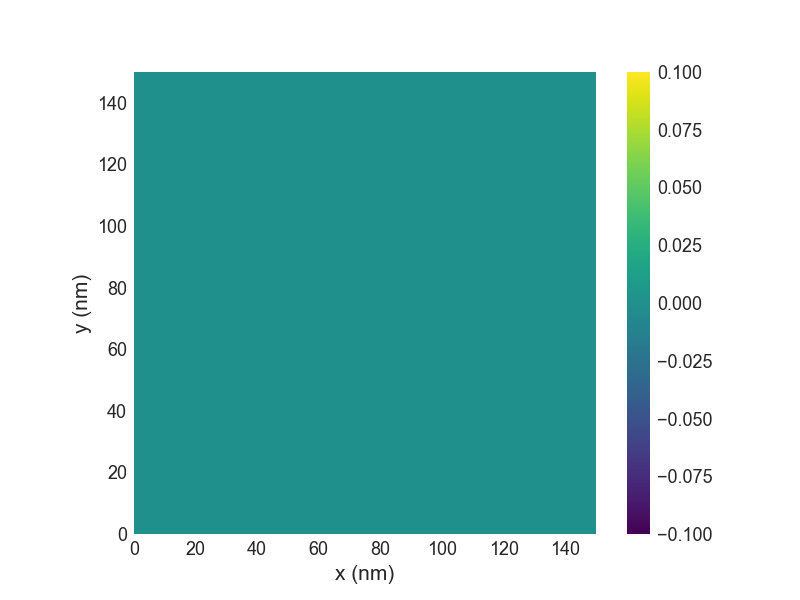

In [26]:
system.m.z.plane(z=5e-9).mpl()

### MFM Calculation

In [33]:
def mfm_phase(system, Q=650, k=4, tip_q=0, tip_m=(0,0,0)):
    stray_field = oc.compute(system.energy.demag.effective_field, system)
    dh_dz = stray_field.derivative('z', n=1)
    d2h_dz2 = stray_field.derivative('z', n=2)
    return (Q*1.256e-6/k)*(tip_q*dh_dz.z+tip_m[0]*d2h_dz2.x+tip_m[1]*d2h_dz2.y+tip_m[2]*d2h_dz2.z)

In [34]:
phase = mfm_phase(system, Q=650, k=3, tip_m=(0,0,1e-13))

Running OOMMF (DockerOOMMFRunner) [2021/07/09 09:32]... (2.2 s)


<IPython.core.display.Javascript object>


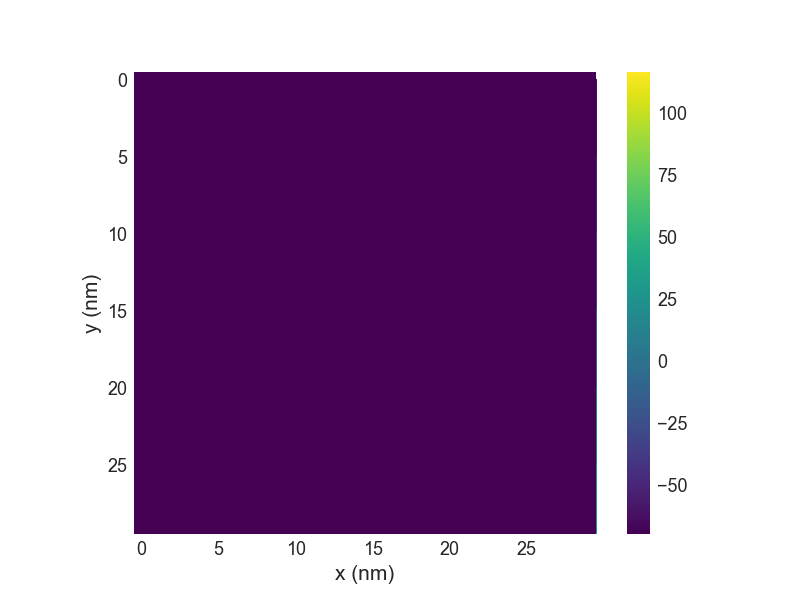

In [35]:
phase.plane(z=50e-9).mpl_scalar()

Calculate stray field (does this give the stray field when an external field is also applied?)

Need to think about convolutions with a tip function? And proper normalisation!

In [89]:
def gaussian(x, y, sigma, mu):
    g = np.exp(-( ((x - mu[0])**2 + (y - mu[1])**2) / ( 2.0 * sigma**2 ) ) )
    return g

In [98]:
f_mesh = phase.plane(z=50e-9).mesh
x, y = np.meshgrid(np.linspace(f_mesh.region.p1[0],f_mesh.region.p2[1],f_mesh.n[0]),
                   np.linspace(f_mesh.region.p1[0],f_mesh.region.p2[1],f_mesh.n[1]))
g = gaussian(x,y, 15e-9, f_mesh.region.centre)

<IPython.core.display.Javascript object>


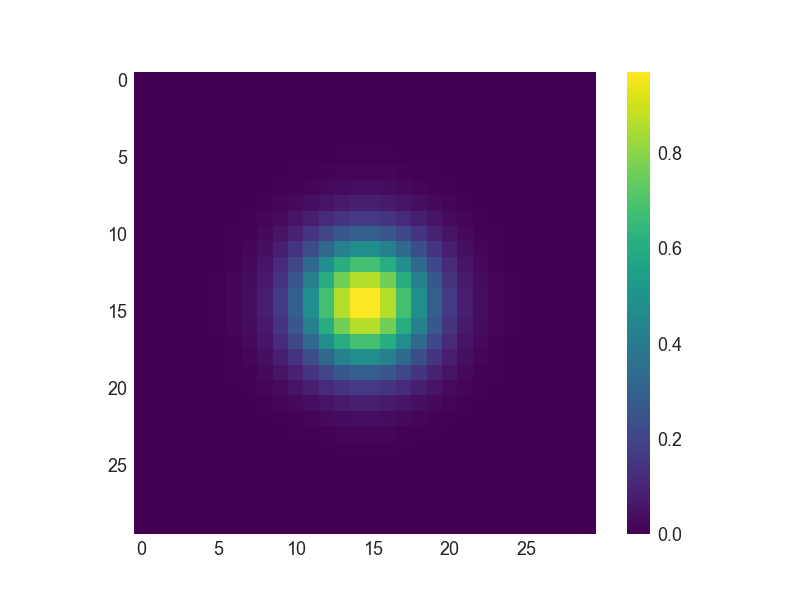

In [99]:
plt.figure()
plt.imshow(g)
plt.colorbar()
plt.show()

In [109]:
g[...,np.newaxis].shape

(30, 30, 1)

In [108]:
f_mesh

Mesh(region=Region(p1=(0.0, 0.0, 4.7499999999999995e-08), p2=(1.5e-07, 1.5e-07, 5.25e-08)), n=(30, 30, 1), bc='', subregions={})

In [114]:
gauss = df.Field(mesh=f_mesh,
                 dim=1,
                 value = g[...,np.newaxis])

ValueError: Unsupported <class 'numpy.ndarray'> or invalid value dimensions.

In [36]:
phase_ft = phase.plane(z=50e-9).fft2
gauss_ft = gauss.fft2

conv_ft = phase_ft*g_ft

conv = conv_ft.ifft2